<a href="https://colab.research.google.com/github/spencer-hann/DeepReinforcementLearning/blob/master/mini_dq_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import gym
from gym import wrappers
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from math import exp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# env = gym.make('CartPole-v1')
# env = wrappers.Monitor(env, "./gym-results", force=True).unwrapped
# env.reset()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:

class SliderGame:
    def __init__(self, size=10, slider_row=None, target_row=None):
        self.n_actions = 2
        self.board = np.empty((size,size), dtype=np.uint8)
        self.size = float(size)

        n = 4
        self.slider_row = slider_row
        if slider_row == None: # nth row up
            self.slider_row = size - n

        self.target_row = target_row
        if target_row == None: # nth row down
            self.target_row = n

        self.reset()

    def reset(self):
        self.board[...] = 0

        self.target = np.random.randint(self.size)
        self.slider = np.random.randint(self.size)

        self.board[self.target_row, self.target] = 1
#         self.board[:, self.target] = 1
        self.board[self.slider_row, self.slider] = 1

    def step(self, action):
        self.board[self.slider_row, self.slider] = 0
        
        previous = (self.slider - self.target)**2

        if action == 0: # move left
            self.slider -= 1
        else: # action == 1 move right
            self.slider += 1

        # negative reward + game over for going out of bounds
        if self.slider < 0 or self.slider >= self.size:
            return {'win':False}, -2., True, None
#             return {'win':False}, -1. * self.size, True, None

        self.board[self.slider_row, self.slider] = 1

        # reward based on closeness of slider and target
#         reward = (self.size / 2) - float(abs(self.slider - self.target))
#         reward = self.size - float((self.slider - self.target)**2)

#         reward = float(np.sign(previous - (self.slider - self.target)**2))
        reward = .5 if previous - (self.slider - self.target)**2 > 0 else -1.
        obs = {'win':None}
        if self.slider == self.target:
            done = True
            reward = 2. #self.size
            obs['win'] = True
        else:
            done = False
#             reward = 0.

        # Nones to match OpenAI Gym's step function
        return obs, reward, done, None

    def __str__(self):
        return str(self.board)


env = SliderGame()

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        k = 3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=k, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=k, stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=k, stride=1)
        self.bn3 = nn.BatchNorm2d(32)
#         self.conv_drop = nn.Dropout2d(p=0.05)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = k, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
#         x = self.conv_drop(x)
        x = F.relu(self.bn2(self.conv2(x)))
#         x = self.conv_drop(x)
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [0]:
resize = T.Compose([T.ToPILImage(),
#                     T.Resize((40,40), interpolation=Image.CUBIC),
                    T.ToTensor(),
                   ])

def get_screen():
    screen = np.expand_dims(env.board, axis=2)
    return resize(screen).unsqueeze(0).to(device)

# env.reset()
# img = get_screen().cpu()
# print(type(img))
# print(img.dtype)
# print(img.shape)
# img = img.squeeze().numpy()
# plt.imshow(img, interpolation='none', cmap="gray")
# plt.title('Example extracted screen')
# plt.show()

In [0]:
BATCH_SIZE = 32
GAMMA = 0.8 # original 0.999
EPS_START = .9
EPS_END = 0.05
EPS_DECAY = 800
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
screen_height, screen_width = env.board.shape

# Get number of actions from gym action space
n_actions = env.n_actions

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.00008)#, weight_decay=0.0001
memory = ReplayMemory(20_000)


steps_done = 0

def select_action(state, testing=False):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold or testing:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             return policy_net(state).max(1)[1].view(1, 1)
            tmp = policy_net(state)
            return tmp.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [0]:
thresholds = []
rewards = []

def plot_rewards():
    plt.xlabel('Episode')
    rewards_tmp = np.array(rewards)
    plt.plot(rewards_tmp, '+', label="rewards")
    if thresholds:
        plt.plot(np.array(thresholds), label="epsilon")
        means = []
        for i,r in enumerate(rewards_tmp):
            means.append(rewards_tmp[max(0,i-40):i+1].mean())
        plt.plot(means, label="moving mean")
        plt.title('Training')
    else:
        mean = rewards_tmp.mean()
        plt.axhline(mean, label=f'mean:{mean:.2}')
        plt.title('Testing')
        
    plt.grid(); plt.legend(); plt.show()

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [90]:
from tqdm import tqdm

rewards = [0]
thresholds = []

timeout_limit = 400
timeout_count = 0

num_episodes = 1000
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
#     if i_episode > num_episodes * .5: EPS_END = 0    
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        obs, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        
#         print(reward.item())
#         img = get_screen().cpu().squeeze().numpy()
#         plt.imshow(img, interpolation='none', cmap="gray")
#         plt.show()
        

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done or t > timeout_limit:
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                exp(-1. * steps_done / EPS_DECAY)
            thresholds.append(eps_threshold)
            rewards.append(1 if obs['win'] else 0)
            if t > timeout_limit:
                timeout_count += 1
            break
    if (i_episode+1) % 50 == 0:
        print(f'\tMean:{np.mean(rewards[-50:]):.4}\teps:{np.mean(thresholds[-50:]):.4}\tTOrate:{timeout_count / 50:.2}')
        timeout_count = 0

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

  5%|▌         | 51/1000 [00:05<02:20,  6.77it/s]

	Mean:0.72	eps:0.5592	TOrate:0.0


 10%|▉         | 99/1000 [00:35<20:06,  1.34s/it]

	Mean:0.72	eps:0.08633	TOrate:0.12


 15%|█▍        | 148/1000 [00:51<04:53,  2.90it/s]

	Mean:0.76	eps:0.05003	TOrate:0.06


 20%|█▉        | 199/1000 [01:12<05:46,  2.31it/s]

	Mean:0.82	eps:0.05	TOrate:0.1


 25%|██▌       | 252/1000 [01:26<02:10,  5.74it/s]

	Mean:0.86	eps:0.05	TOrate:0.04


 30%|███       | 303/1000 [01:36<01:19,  8.80it/s]

	Mean:0.9	eps:0.05	TOrate:0.02


 35%|███▌      | 353/1000 [01:42<03:14,  3.33it/s]

	Mean:0.92	eps:0.05	TOrate:0.02


 40%|███▉      | 399/1000 [01:50<03:23,  2.95it/s]

	Mean:0.86	eps:0.05	TOrate:0.02


 46%|████▌     | 456/1000 [01:57<00:48, 11.17it/s]

	Mean:0.86	eps:0.05	TOrate:0.0


 51%|█████     | 511/1000 [02:06<02:26,  3.34it/s]

	Mean:0.8	eps:0.05	TOrate:0.02


 55%|█████▌    | 550/1000 [02:09<00:57,  7.87it/s]

	Mean:0.86	eps:0.05	TOrate:0.0


 60%|██████    | 603/1000 [02:14<00:20, 19.23it/s]

	Mean:0.88	eps:0.05	TOrate:0.0


 65%|██████▍   | 649/1000 [02:34<02:01,  2.88it/s]

	Mean:0.8	eps:0.05	TOrate:0.12


 70%|██████▉   | 698/1000 [02:50<00:59,  5.11it/s]

	Mean:0.82	eps:0.05	TOrate:0.08


 76%|███████▌  | 755/1000 [02:58<00:25,  9.55it/s]

	Mean:0.82	eps:0.05	TOrate:0.02


 80%|████████  | 804/1000 [03:01<00:09, 21.73it/s]

	Mean:0.9	eps:0.05	TOrate:0.0


 85%|████████▌ | 853/1000 [03:07<00:28,  5.14it/s]

	Mean:0.88	eps:0.05	TOrate:0.0


 90%|█████████ | 901/1000 [03:10<00:12,  7.85it/s]

	Mean:0.94	eps:0.05	TOrate:0.0


 96%|█████████▌| 955/1000 [03:19<00:15,  2.86it/s]

	Mean:0.8	eps:0.05	TOrate:0.0


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]

	Mean:0.82	eps:0.05	TOrate:0.0
Complete


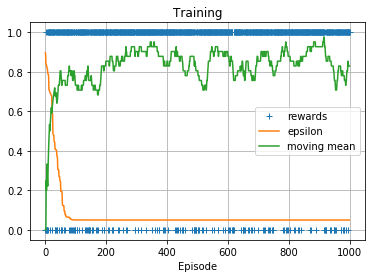

0.8361638361638362


In [91]:
plot_rewards()
print(np.mean(rewards))

In [0]:
policy_net.eval()
torch.no_grad();

In [93]:
from tqdm import tqdm

rewards = []
thresholds = []

EPS_END = 0

timeout_count = 0

num_episodes = 200
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state, testing = True)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done or t > timeout_limit:
            rewards.append(1 if reward.item() > 0 else 0)
            break
    if (i_episode+1) % 50 == 0:
        print(f'\tMean:{np.mean(rewards[-50:]):.4}\tTOrate:{timeout_count / i_episode%50:.2}')
        timeout_count = 0


print('Complete')

 25%|██▌       | 50/200 [00:02<00:14, 10.58it/s]

	Mean:0.82	TOrate:0.0


 50%|█████     | 100/200 [00:04<00:07, 12.70it/s]

	Mean:0.88	TOrate:0.0


 74%|███████▍  | 148/200 [00:09<00:05,  9.80it/s]

	Mean:0.84	TOrate:0.0


100%|██████████| 200/200 [00:12<00:00, 16.16it/s]

	Mean:0.8	TOrate:0.0
Complete


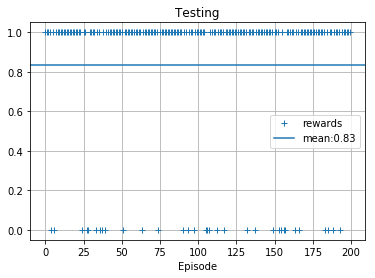

0.835


In [94]:
plot_rewards()
print(np.mean(rewards))

In [95]:
from tqdm import tqdm

rewards = []
thresholds = []

env.target_row -= 1
env.slider_row += 1

timeout_count = 0

num_episodes = 200
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state, testing = True)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Move to the next state
        state = next_state

        if done or t > 1000:
            rewards.append(1 if reward.item() > 0 else 0)
            break
    if (i_episode+1) % 50 == 0:
        print(f'\tMean:{np.mean(rewards[-50:]):.4}\tTOrate:{timeout_count / i_episode%50:.2}')
        timeout_count = 0


print('Complete')

 24%|██▍       | 49/200 [00:19<01:27,  1.73it/s]

	Mean:0.54	TOrate:0.0


 50%|█████     | 100/200 [00:42<00:53,  1.88it/s]

	Mean:0.58	TOrate:0.0


 75%|███████▌  | 150/200 [01:08<00:29,  1.72it/s]

	Mean:0.46	TOrate:0.0


100%|██████████| 200/200 [01:32<00:00,  1.67it/s]

	Mean:0.58	TOrate:0.0
Complete


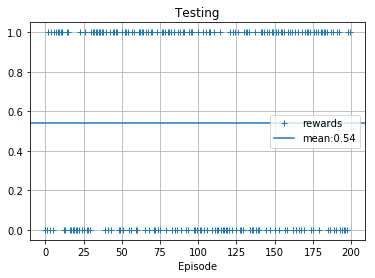

0.54


In [96]:
plot_rewards()
print(np.mean(rewards))